# Theoretical PSD for the Matsuda-Komaki (MK) model

Here we aim to obtain a theoretical closed-form representation for the PSD function
of the MK model. We represent the MK model in three different ways to find the corresponding
theoretical PSD:
1. Autoregressive process (AR)
2. Autoregressive Moving Average process (ARMA)
3. Multivariate Autoregressive process (MAR)

To find out, which representation is correct, we also estimate the spectrum of simulated data.
To simulate the ground-truth PSD, we sample from the MK model and then estimate the spectrum,
using Welch's approach.

## MK model as ARMA process

Consider MK model for one oscillation:
$$ \begin{bmatrix} x_1^n \\ x_2^n \end{bmatrix} =
\begin{pmatrix} A \cos{\omega} & -A \sin{\omega} \\
A \sin{\omega} & A \cos{\omega} \end{pmatrix}
\begin{bmatrix} x_1^{n-1} \\ x_2^{n-1} \end{bmatrix} + \begin{bmatrix} w_1^{n} \\
w_2^{n} \end{bmatrix}
$$

Same holds for the $n-1$-st step:
$$ \begin{bmatrix}
x_1^{n-1} \\ x_2^{n-1} \end{bmatrix} = \begin{pmatrix} A \cos{\omega} & -A
\sin{\omega} \\ A \sin{\omega} & A \cos{\omega} \end{pmatrix} \begin{bmatrix}
x_1^{n-2} \\ x_2^{n-2} \end{bmatrix} + \begin{bmatrix} w_1^{n-1} \\ w_2^{n-1}
\end{bmatrix}
$$

Let's take the first equation from this and solve for $x_2^{n-2}$:
$$
x_1^{n-1} = A\cos{\omega} x_1^{n-2} - A\sin{\omega}x_2^{n-2} +
w_1^{n-1}\implies x_2^{n-2} = \frac{-x_1^{n-1} + A\cos{\omega}x_1^{n-2} +
w_1^{n-1}}{A\sin{\omega}}
$$

Substitute $x_2^{n-2}$ into the second equation
for the $n-1$ step:
$$
x_2^{n-1} = A\sin{\omega}x_1^{n-2} +
A\cos{\omega}\frac{-x_1^{n-1} + A\cos{\omega}x_1^{n-2} +
w_1^{n-1}}{A\sin{\omega}} + w_2^{n-1}
$$

And substitute the expression for
$x_2^{n-1}$ into the first MK equation for step $n$:
$$
x_1^n = A\cos{\omega}x_1^{n-1} + A^2\sin^2{\omega}x_1^{n-2} -
        A\cos{\omega}(-x_1^{n-1} + A\cos{\omega}x_1^{n-2} + w_1^{n-1})
        -A\sin{\omega}w_2^{n-1} +w_1^n
$$

After the simplification, we get
$$
x_1^n = 2A\cos{\omega}x_1^{n-1} - A^2x_1^{n-2} + w_1^n
- A\cos{\omega}w_1^{n-1} - A\sin{\omega}w_2^{n-1}
$$

The equation above gives us clear AR part for the MK model. The noise terms do
not directly conform to the MA structure. The noise is highly correlated
between the time stamps since $A\cos{\omega}\approx 1$. However, as mentioned
in [1], these noise terms can be transformed to match the familiar MA
structure, so the equation above is in fact equivalent to the ARMA(2, 1)
process.

We will use the AR part of the representation above for the `theor_psd_mk_ar()`
below, and the complete ARMA form, as specified in [1] for the
`theor_psd_mk_arma()`

## MK model as MAR

We note, that the MK model in its original form is actually a multivariate
autoregressive process. PSD function for the MAR has a known form and is described in [2].
We use it for the `theor_psd_mk_mar()` function below.


References
----------
.. [1] Matsuda, Takeru, and Fumiyasu Komaki. “Time Series Decomposition into
Oscillation Components and Phase Estimation.” Neural Computation 29, no. 2
(February 2017): 332–67. https://doi.org/10.1162/NECO_a_00916.

.. [2] Kitagawa, Genshiro. 2010. Introduction to Time Series Modeling. 0 ed.
Chapman and Hall/CRC. https://doi.org/10.1201/9781584889229.

In [1]:
# We start with the imports


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch

In [2]:
# Now, let's define functions representing the theoretical PSD for the 3 cases


def theor_psd_mk_ar(f, s, A, f0, sr):
    phi = 2 * np.pi * f0 / sr
    psi = 2 * np.pi * f / sr
    denom_ft = 1 - 2 * A * np.cos(phi) * np.exp(-1j * psi) + A**2 * np.exp(-2j * psi)
    return s**2 / np.abs(denom_ft) ** 2


def theor_psd_mk_arma(f, s, A, f0, sr):
    phi = 2 * np.pi * f0 / sr
    psi = 2 * np.pi * f / sr

    a = (1 - 2 * A**2 * np.cos(phi) ** 2 + A**4 * np.cos(2 * phi)) / (A**3 - A) / np.cos(phi)
    b = 0.5 * (a - 2 * A * np.cos(phi) + np.sqrt((a - 2 * A * np.cos(phi)) ** 2 - 4))
    V = -(s**2) * A * np.cos(phi) / b

    denom_ft = 1 - 2 * A * np.cos(phi) * np.exp(-1j * psi) + A**2 * np.exp(-2j * psi)
    num_ft = 1 + b * np.exp(-1j * psi)
    return V * np.abs(num_ft) ** 2 / np.abs(denom_ft) ** 2


def theor_psd_mk_mar(f, s, A, f0, sr):
    phi = 2 * np.pi * f0 / sr
    psi = 2 * np.pi * f / sr

    denom_ft = 1 - 2 * A * np.cos(phi) * np.exp(-1j * psi) + A**2 * np.exp(-2j * psi)
    num_ft_abs_sq = 1 - 2 * A * np.cos(phi) * np.cos(psi) + A**2
    return s**2 * num_ft_abs_sq / np.abs(denom_ft) ** 2

In [3]:
# Setup params and generate data
def complex_noise_step():
    return np.random.randn() + 1j * np.random.randn()


s_continuous, A, f0, sr = 1, 0.99, 20, 1000

# N.B.: variances for the discrete and continuous case are different!!!
s_discrete = s_continuous * np.sqrt(sr)

n_samp = 10_000
x = np.random.randn() + 1j * np.random.randn()
mk_samples = [x]
Phi = A * np.exp(1j * 2 * np.pi * f0 / sr)
for _ in range(n_samp):
    mk_samples.append(Phi * mk_samples[-1] + complex_noise_step() * s_discrete)
mk_samples = np.array(mk_samples)

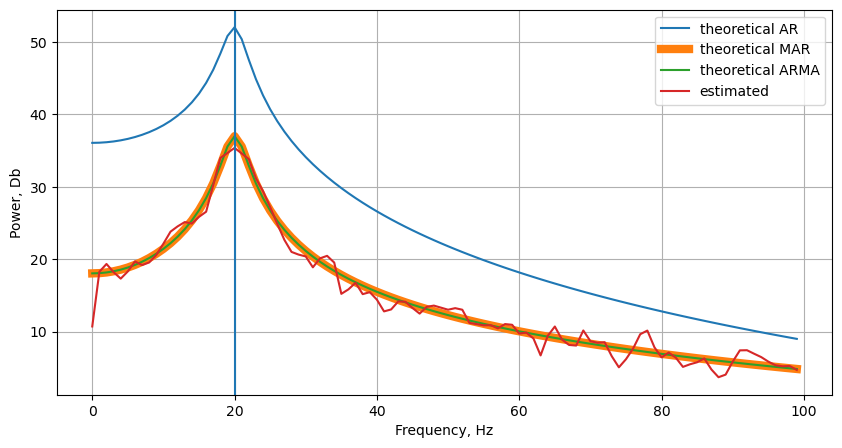

In [4]:
# And plot the results
def to_db(arr):
    return 10 * np.log10(arr)


ff, psd_est = welch(np.real(mk_samples), fs=sr, nperseg=1000)
FREQ_LIM = 100
psd_est = np.array([p / 2 for f, p in zip(ff, psd_est) if f < FREQ_LIM])
ff = np.array([f for f in ff if f < FREQ_LIM])

psd_mar = np.array([theor_psd_mk_mar(f, s_continuous, A, f0, sr) for f in ff])
psd_ar = np.array([theor_psd_mk_ar(f, s_continuous, A, f0, sr) for f in ff])
psd_arma = np.array([theor_psd_mk_arma(f, s_continuous, A, f0, sr) for f in ff])

fig = plt.figure(figsize=(10, 5))
plt.plot(ff, to_db(psd_ar), label="theoretical AR")
plt.plot(ff, to_db(psd_mar), label="theoretical MAR", linewidth=6)
plt.plot(ff, to_db(psd_arma), label="theoretical ARMA")
plt.plot(ff, to_db(psd_est), label="estimated")

plt.axvline(x=f0)
plt.legend()
plt.xlabel("Frequency, Hz")
plt.ylabel("Power, Db")
plt.grid()
plt.show()

# Discussion
As we can see, the MAR and ARMA representations really lead to the same correct
PSD representation: they perfectly align with each other and have a good match with the
estimated spectrum.

At the same time, ignoring noise correlation between the time steps leads to
though the similar spectrum, but still different. Also note, that the power is overestimated